# Setup the environment

In [15]:
#!pip install --upgrade google-cloud-bigquery
#!pip install --upgrade pyarrow

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.cloud import bigquery

# Library Functions

In [10]:
def load_data_from_bq(sql, credential_json_file):

    %load_ext google.cloud.bigquery

    import os
    from google.cloud import bigquery
    from google.oauth2 import service_account

    os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=credential_json_file
    credentials = service_account.Credentials.from_service_account_file(credential_json_file)

    bqclient = bigquery.Client(credentials=credentials)

    # Download query results.
    query_string = sql

    df = (
        bqclient.query(query_string)
            .result()
            .to_dataframe(
            # Optionally, explicitly request to use the BigQuery Storage API. As of
            # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
            # API is used by default.
            create_bqstorage_client=True,
        )
    )

    return df, bqclient

# Load Data

In [12]:
df_original, client = load_data_from_bq(sql="""SELECT * FROM
        `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`""",
                                credential_json_file="my-bq-project-338012-b4ab7ea646dc.json")

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [13]:
df_original.head()

,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,clientId,channelGrouping,socialEngagementType
0,NaN,1,1501583974,1501583974,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Car...",[],"[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2248281639583218707,None,None,Organic Search,Not Socially Engaged
1,NaN,1,1501616585,1501616585,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...",8647436381089107732,None,None,Organic Search,Not Socially Engaged
2,NaN,1,1501583344,1501583344,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Asia', 'subContinent': 'Souther...","[{'index': 4, 'value': 'APAC'}]","[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2055839700856389632,None,None,Organic Search,Not Socially Engaged
3,NaN,1,1501573386,1501573386,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Europe', 'subContinent': 'Weste...","[{'index': 4, 'value': 'EMEA'}]","[{'hitNumber': 1, 'time': 0, 'hour': 0, 'minut...",0750846065342433129,None,None,Direct,Not Socially Engaged
4,NaN,8,1501651467,1501651467,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 22, 'minu...",0573427169410921198,None,None,Organic Search,Not Socially Engaged


# Create BQ dataset

In [8]:
! bq mk my-bq-project-338012:kmeans



Updates are available for some Cloud SDK components.  To install them,
please run:
  $ gcloud components update


Welcome to BigQuery! This script will walk you through the 
process of initializing your .bigqueryrc configuration file.

First, we need to set up your credentials if they do not 
already exist.

Credential creation complete. Now we will select a default project.

List of projects:
  #    projectId    friendlyName  
 --- ------------- -------------- 
  1   sbilife-o2o   SBILife O2O   
Setting sbilife-o2o as the default.

BigQuery configuration complete! Type "bq" to get started.

BigQuery error in mk operation: Access Denied: Project my-bq-project-338012:
User does not have bigquery.datasets.create permission in project my-bq-
project-338012.


In [17]:
ga360_only_view = 'GA360_View'
shared_dataset_ref = client.dataset('kmeans')
ga360_view_ref = shared_dataset_ref.table(ga360_only_view)
ga360_view = bigquery.Table(ga360_view_ref)

ga360_query = '''
SELECT
  fullVisitorID,
  # This will be used to generate random data.
  ABS(farm_fingerprint(fullVisitorID)) AS Hashed_fullVisitorID,
  # You can aggregate this because an
  # operating system is tied to a fullVisitorID.
  MAX(device.operatingSystem) AS OS,
  SUM (CASE
       WHEN REGEXP_EXTRACT (v2ProductCategory,
                           r'^(?:(?:.*?)Home/)(.*?)/')
                           = 'Apparel' THEN 1 ELSE 0 END) AS Apparel,
  SUM (CASE
       WHEN REGEXP_EXTRACT (v2ProductCategory,
                           r'^(?:(?:.*?)Home/)(.*?)/')
                           = 'Office' THEN 1 ELSE 0 END) AS Office,
  SUM (CASE
       WHEN REGEXP_EXTRACT (v2ProductCategory,
                           r'^(?:(?:.*?)Home/)(.*?)/')
                           = 'Electronics' THEN 1 ELSE 0 END) AS Electronics,
  SUM (CASE
       WHEN REGEXP_EXTRACT (v2ProductCategory,
                           r'^(?:(?:.*?)Home/)(.*?)/')
                           = 'Limited Supply' THEN 1 ELSE 0 END) AS LimitedSupply,
  SUM (CASE
       WHEN REGEXP_EXTRACT (v2ProductCategory,
                           r'^(?:(?:.*?)Home/)(.*?)/')
                           = 'Accessories' THEN 1 ELSE 0 END) AS Accessories,
  SUM (CASE
       WHEN REGEXP_EXTRACT (v2ProductCategory,
                           r'^(?:(?:.*?)Home/)(.*?)/')
                           = 'Shop by Brand' THEN 1 ELSE 0 END) AS ShopByBrand,
  SUM (CASE
       WHEN REGEXP_EXTRACT (v2ProductCategory,
                           r'^(?:(?:.*?)Home/)(.*?)/')
                           = 'Bags' THEN 1 ELSE 0 END) AS Bags,
  ROUND (SUM (productPrice/1000000),2) AS totalSpent_USD
  FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
  UNNEST(hits) AS hits,
  UNNEST(hits.product) AS hits_product
WHERE
  _TABLE_SUFFIX BETWEEN '20160801'
  AND '20160831'
  AND geoNetwork.country = 'United States'
  AND type = 'EVENT'
GROUP BY
  1,
  2
'''

ga360_view.view_query = ga360_query.format('my-bq-project-338012')
ga360_view = client.create_table(ga360_view)


In [18]:
# Show a sample of GA360 data

ga360_query_df = f'''
SELECT * FROM {ga360_view.full_table_id.replace(":", ".")}
ORDER BY fullVisitorID
LIMIT 5
'''

job_config = bigquery.QueryJobConfig()

# Start the query
query_job = client.query(ga360_query_df, job_config=job_config) #API Request
df_ga360 = query_job.result()
df_ga360 = df_ga360.to_dataframe()

df_ga360

,fullVisitorID,Hashed_fullVisitorID,OS,Apparel,Office,Electronics,LimitedSupply,Accessories,ShopByBrand,Bags,totalSpent_USD
0,000005103959234087,4337061952752469967,Android,0,1,0,0,0,0,0,11.99
1,0003130024474361102,1959238978674290279,Chrome OS,0,22,0,0,0,0,0,68.89
2,000412118581900885,2335900684219890205,Windows,4,0,0,2,0,0,0,227.94
3,0004824403431530928,7205701007295976334,Macintosh,10,2,0,6,2,0,0,1044.82
4,0006056564841557616,8664318594051821921,Macintosh,2,0,0,0,0,0,0,33.98


# Generate Demographic Data

In a production use case, you would want to use your own data from a customer relationship management (CRM) system. You would skip this step and proceed to the next, which is joining the CRM data with the aggregated customer transaction data.

In [19]:
CRM_only_view = 'CRM_View'
shared_dataset_ref = client.dataset('kmeans')
CRM_view_ref = shared_dataset_ref.table(CRM_only_view)
CRM_view = bigquery.Table(CRM_view_ref)

# The query below works by hashing the fullVisitorID, which creates a
# random distribution. It uses modulo to artificially split gender and
# household income distribution.
CRM_query = '''
SELECT
  fullVisitorID,
IF
  (MOD(Hashed_fullVisitorID,2) = 0,
    "M",
    "F") AS gender,
  # Generate household income
  CASE
    WHEN MOD(Hashed_fullVisitorID,10) = 0 THEN 55000
    WHEN MOD(Hashed_fullVisitorID,10) < 3 THEN 65000
    WHEN MOD(Hashed_fullVisitorID,10) < 7 THEN 75000
    WHEN MOD(Hashed_fullVisitorID,10) < 9 THEN 85000
    WHEN MOD(Hashed_fullVisitorID,10) = 9 THEN 95000
  ELSE
  Hashed_fullVisitorID
END
  AS hhi
FROM (
  SELECT
    fullVisitorID,
    ABS(farm_fingerprint(fullVisitorID)) AS Hashed_fullVisitorID,
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits,
    UNNEST(hits.product) AS hits_product
      WHERE
    _TABLE_SUFFIX BETWEEN '20160801'
    AND '20160831'
    AND geoNetwork.country = 'United States'
    AND type = 'EVENT'
  GROUP BY
    1,
    2)
'''

CRM_view.view_query = CRM_query.format('my-bq-project-338012')
CRM_view = client.create_table(CRM_view)

In [20]:
# See an output of the synthetic CRM data

CRM_query_df = f'''
SELECT * FROM {CRM_view.full_table_id.replace(":", ".")}
ORDER BY fullVisitorID
LIMIT 5
'''

job_config = bigquery.QueryJobConfig()

# Start the query
query_job = client.query(CRM_query_df, job_config=job_config)
df_CRM = query_job.result()
df_CRM = df_CRM.to_dataframe()

df_CRM

,fullVisitorID,gender,hhi
0,000005103959234087,F,85000
1,0003130024474361102,F,95000
2,000412118581900885,F,75000
3,0004824403431530928,M,75000
4,0006056564841557616,F,65000


# Create the Training dataset

In [21]:
# Build a final view, which joins GA360 data with CRM data

final_data_view = 'Final_View'
shared_dataset_ref = client.dataset('kmeans')
final_view_ref = shared_dataset_ref.table(final_data_view)
final_view = bigquery.Table(final_view_ref)

final_data_query = f'''
SELECT
    g.*,
    c.* EXCEPT(fullVisitorId)
FROM {ga360_view.full_table_id.replace(":", ".")} g
JOIN {CRM_view.full_table_id.replace(":", ".")} c
ON g.fullVisitorId = c.fullVisitorId
'''

final_view.view_query = final_data_query.format('my-bq-project-338012')
final_view = client.create_table(final_view)

print(f"Successfully created view at {final_view.full_table_id}")

Successfully created view at my-bq-project-338012:kmeans.Final_View


In [22]:
# Show final data used before modeling

sql_demo = f'''
SELECT * FROM {final_view.full_table_id.replace(":", ".")}
ORDER BY fullVisitorID
LIMIT 5
'''

job_config = bigquery.QueryJobConfig()

# Start the query
query_job = client.query(sql_demo, job_config=job_config)
df_demo = query_job.result()
df_demo = df_demo.to_dataframe()

df_demo

,fullVisitorID,Hashed_fullVisitorID,OS,Apparel,Office,Electronics,LimitedSupply,Accessories,ShopByBrand,Bags,totalSpent_USD,gender,hhi
0,000005103959234087,4337061952752469967,Android,0,1,0,0,0,0,0,11.99,F,85000
1,0003130024474361102,1959238978674290279,Chrome OS,0,22,0,0,0,0,0,68.89,F,95000
2,000412118581900885,2335900684219890205,Windows,4,0,0,2,0,0,0,227.94,F,75000
3,0004824403431530928,7205701007295976334,Macintosh,10,2,0,6,2,0,0,1044.82,M,75000
4,0006056564841557616,8664318594051821921,Macintosh,2,0,0,0,0,0,0,33.98,F,65000


# Create, Train & Deploy the Model

In [23]:
PROJECT_ID = "my-bq-project-338012"

def makeModel (n_Clusters, Model_Name):
    sql =f'''
    CREATE OR REPLACE MODEL `{PROJECT_ID}.kmeans.{Model_Name}`
    OPTIONS(model_type='kmeans',
    kmeans_init_method = 'KMEANS++',
    num_clusters={n_Clusters}) AS
    SELECT * except(fullVisitorID, Hashed_fullVisitorID) FROM `{final_view.full_table_id.replace(":", ".")}`
    '''
    job_config = bigquery.QueryJobConfig()
    client.query(sql, job_config=job_config)

In [24]:
model_test_name = "test"
makeModel(3, model_test_name)

In [27]:
for model in client.list_models('kmeans'):
    print(model)

Model(reference=ModelReference(project_id='my-bq-project-338012', dataset_id='kmeans', model_id='test'))


In [28]:
# Delete the test model

model_id = "kmeans."+model_test_name
client.delete_model(model_id)
print(f"Deleted model '{model_id}'")

Deleted model 'kmeans.test'


# Improve the Model

Determining the right number of clusters — this is the "k" in "k-means" — depends on your use case. It is sometimes easy to determine how many clusters you need. For example, if you are processing images of handwritten single digits, you need 10 clusters, one each for digits 0-9. For use cases that are less obvious, you can experiment with multiple versions of the model that use different numbers of clusters. Comparing different versions of the model lets you see which performs best in terms of grouping your data while minimizing error within each cluster.

You can determine which model version provides the best groupings by using the elbow method, which is a way of charting loss against the number of clusters in the model, in combination with the model's Davies–Bouldin score. This score indicates how different a cluster's data points are from one another. It is defined as the ratio between the scatter of the data points within a given cluster and the scatter of the clusters themselves. A lower value inidcates better clustering.

# Create multiple models for comparison

In [29]:
low_k = 3
high_k = 15
model_prefix_name = 'kmeans_clusters_'

lst = list(range (low_k, high_k+1)) #build list to iterate through k values

for k in lst:
    model_name = model_prefix_name + str(k)
    makeModel(k, model_name)

In [36]:
models = client.list_models('kmeans')
print("Listing current models:")
for model in models:
    full_model_id = f"{model.dataset_id}.{model.model_id}"
    print(full_model_id)

Listing current models:
kmeans.kmeans_clusters_10
kmeans.kmeans_clusters_11
kmeans.kmeans_clusters_12
kmeans.kmeans_clusters_13
kmeans.kmeans_clusters_14
kmeans.kmeans_clusters_15
kmeans.kmeans_clusters_3
kmeans.kmeans_clusters_4
kmeans.kmeans_clusters_5
kmeans.kmeans_clusters_6
kmeans.kmeans_clusters_7
kmeans.kmeans_clusters_8
kmeans.kmeans_clusters_9


# Compare Model Performance

Use the folowing procedure to compare the performance of the different models by reviewing the mean squared distance, which identifies the loss for the model, and the Davies–Bouldin score for each model.



In [37]:
# This creates a dataframe with each model name, the Davies Bouldin Index, and Loss.

df = pd.DataFrame(columns=['davies_bouldin_index', 'mean_squared_distance'])
models = client.list_models('kmeans')
for model in models:
    full_model_id = f"{model.dataset_id}.{model.model_id}"
    sql =f'''
        SELECT
            davies_bouldin_index,
            mean_squared_distance
        FROM ML.EVALUATE(MODEL `{full_model_id}`)
    '''

    job_config = bigquery.QueryJobConfig()

    # Start the query, passing in the extra configuration.
    query_job = client.query(sql, job_config=job_config)
    df_temp = query_job.to_dataframe()  # Wait for the job to complete.
    df_temp['model_name'] = model.model_id
    df =  pd.concat([df, df_temp], axis=0)

In [38]:
df['n_clusters'] = df['model_name'].str.split('_').map(lambda x: x[2])
df['n_clusters'] = df['n_clusters'].apply(pd.to_numeric)
df = df.sort_values(by='n_clusters', ascending=True)
df

,davies_bouldin_index,mean_squared_distance,model_name,n_clusters
0,1.532606,8.499200,kmeans_clusters_3,3
0,1.918523,8.524787,kmeans_clusters_4,4
0,1.330396,7.353304,kmeans_clusters_5,5
0,1.253412,6.788111,kmeans_clusters_6,6
0,1.610131,6.166067,kmeans_clusters_7,7
0,1.589554,5.895958,kmeans_clusters_8,8
0,1.141568,5.888914,kmeans_clusters_9,9
0,1.084747,6.150114,kmeans_clusters_10,10
0,1.250368,4.985817,kmeans_clusters_11,11
0,1.395609,4.796084,kmeans_clusters_12,12


<AxesSubplot:xlabel='n_clusters'>

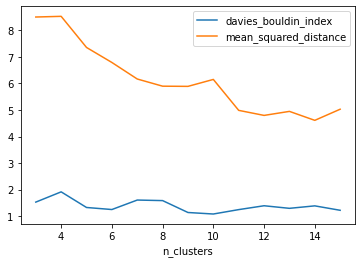

In [39]:
df.plot.line(x='n_clusters', y=['davies_bouldin_index', 'mean_squared_distance'])

There is no perfect approach to determining the optimal number of clusters for a use case. We recommend taking the following approach when making this decision:

- Apply the elbow method, and see if it shows you a clear place where loss evens out.
- Consider the Davies-Bouldin scores for the models.
- Consider business rules or requirements that might affect how many clusters you want to work with.
- Choose the model that meets your business requirements and has the best combination of low loss and low Davies-Bouldin score.

# Analyze the data clusters in the selected Model

We select Model 4 for simplicity sake.

In [40]:
model_to_use = 'kmeans_clusters_4' # Edit this to use a different model
final_model = 'kmeans.'+model_to_use

pd.set_option('max_colwidth', 400)

sql_get_attributes = f'''
SELECT
  centroid_id,
  feature,
  categorical_value
FROM
  ML.CENTROIDS(MODEL {final_model})
WHERE
  feature IN ('gender')
'''

job_config = bigquery.QueryJobConfig()

# Start the query
query_job = client.query(sql_get_attributes, job_config=job_config)
df_attributes = query_job.result()
df_attributes = df_attributes.to_dataframe()
df_attributes

,centroid_id,feature,categorical_value
0,1,gender,"[{'category': 'F', 'value': 1.0}]"
1,2,gender,"[{'category': 'F', 'value': 0.9522144522144522}, {'category': 'M', 'value': 0.047785547785547784}]"
2,3,gender,"[{'category': 'F', 'value': 0.46153846153846156}, {'category': 'M', 'value': 0.5384615384615384}]"
3,4,gender,"[{'category': 'F', 'value': 0.3728234336859235}, {'category': 'M', 'value': 0.6271765663140765}]"


Calculate the summary statistics on the cluster data

In [41]:
sql_get_numerical_attributes = f'''
WITH T AS (
SELECT
  centroid_id,
  ARRAY_AGG(STRUCT(feature AS name,
                   ROUND(numerical_value,1) AS value)
                   ORDER BY centroid_id)
                   AS cluster
FROM ML.CENTROIDS(MODEL {final_model})
GROUP BY centroid_id
),

Users AS(
SELECT
  centroid_id,
  COUNT(*) AS Total_Users
FROM(
SELECT
  * EXCEPT(nearest_centroids_distance)
FROM
  ML.PREDICT(MODEL {final_model},
    (
    SELECT
      *
    FROM
      {final_view.full_table_id.replace(":", ".")}
      )))
GROUP BY centroid_id
)

SELECT
  centroid_id,
  Total_Users,
  (SELECT value from unnest(cluster) WHERE name = 'Apparel') AS Apparel,
  (SELECT value from unnest(cluster) WHERE name = 'Office') AS Office,
  (SELECT value from unnest(cluster) WHERE name = 'Electronics') AS Electronics,
  (SELECT value from unnest(cluster) WHERE name = 'LimitedSupply') AS LimitedSupply,
  (SELECT value from unnest(cluster) WHERE name = 'Accessories') AS Accessories,
  (SELECT value from unnest(cluster) WHERE name = 'Bags') AS Bags,
  (SELECT value from unnest(cluster) WHERE name = 'ShopByBrand') AS ShopByBrand,
  (SELECT value from unnest(cluster) WHERE name = 'totalSpent_USD') AS totalSpent_USD,
  (SELECT value from unnest(cluster) WHERE name = 'hhi') AS HouseholdIncome

FROM T LEFT JOIN Users USING(centroid_id)
ORDER BY centroid_id ASC
'''

job_config = bigquery.QueryJobConfig()

# Start the query
query_job = client.query(sql_get_numerical_attributes, job_config=job_config)
df_numerical_attributes = query_job.result()
df_numerical_attributes = df_numerical_attributes.to_dataframe()
df_numerical_attributes.head()

,centroid_id,Total_Users,Apparel,Office,Electronics,LimitedSupply,Accessories,Bags,ShopByBrand,totalSpent_USD,HouseholdIncome
0,1,1,0.0,340.0,0.0,0.0,0.0,0.0,0.0,2022.9,75000.0
1,2,1816,3.2,1.0,0.9,0.5,0.5,0.4,0.7,245.8,89178.3
2,3,17,4.3,2.1,1.3,0.3,0.7,-0.0,31.6,1100.5,79615.4
3,4,6041,2.7,0.9,0.7,0.5,0.5,0.3,0.2,207.1,70957.7


# Get predictions

In [42]:
# Use your selected model to assign users into clusters that you can then use for marketing segmentation.

sql_score = f'''
SELECT * EXCEPT(nearest_centroids_distance)
FROM
  ML.PREDICT(MODEL {final_model},
    (
    SELECT
      *
    FROM
      {final_view.full_table_id.replace(":", ".")}
      LIMIT 10))
'''

job_config = bigquery.QueryJobConfig()

# Start the query
query_job = client.query(sql_score, job_config=job_config)
df_score = query_job.result()
df_score = df_score.to_dataframe()

df_score

,CENTROID_ID,fullVisitorID,Hashed_fullVisitorID,OS,Apparel,Office,Electronics,LimitedSupply,Accessories,ShopByBrand,Bags,totalSpent_USD,gender,hhi
0,4,8801752590982652761,196041485918610155,Windows,0,0,0,0,0,0,0,1.99,F,75000
1,4,8355103612289837568,4517905322618972303,Chrome OS,0,0,0,0,1,0,0,1.99,F,75000
2,2,1441301506965036346,8200515500173555177,Macintosh,0,0,2,2,0,0,0,279.96,F,85000
3,2,3339969886638037862,7119993913153820257,Macintosh,19,3,4,0,0,0,1,937.25,F,85000
4,4,9389436583324779454,8827930720867903173,iOS,1,0,0,0,0,0,0,16.99,F,75000
5,4,2166569655396368369,2074409771222667143,Linux,0,1,0,0,0,0,0,10.99,F,75000
6,4,7770850576523573713,1555529942794677513,iOS,0,0,0,0,0,0,0,30.99,F,75000
7,4,716411375745885143,4753108492443265215,iOS,0,0,0,0,0,0,0,425.00,F,75000
8,4,8736975165909803047,6058487005608912672,Chrome OS,0,0,1,0,0,0,0,59.99,M,65000
9,4,2917270086618932592,4544744736098108722,Macintosh,1,0,0,0,0,0,0,64.99,M,65000


# Export data to Google Analytics 360

After you have cluster information for your customers from your k-means model, you can export it to Analytics 360 for use in marketing campaigns.

In [46]:
DATASET_ID = 'kmeans'

sql = f'''CREATE OR REPLACE TABLE `{PROJECT_ID}`.`{DATASET_ID}`.myCustomerDataTable AS (
SELECT * EXCEPT(nearest_centroids_distance)
FROM
ML.PREDICT(MODEL `{final_model}`,
                 (
                         SELECT
                         *
                         FROM
                     `{final_view.full_table_id.replace(":", ".")}`)))'''

print(sql)

CREATE OR REPLACE TABLE `my-bq-project-338012`.`kmeans`.myCustomerDataTable AS (
SELECT * EXCEPT(nearest_centroids_distance)
FROM
ML.PREDICT(MODEL `kmeans.kmeans_clusters_4`,
                 (
                         SELECT
                         *
                         FROM
                     `my-bq-project-338012.kmeans.Final_View`)))


In [47]:
job_config = bigquery.QueryJobConfig()
query_job = client.query(sql, job_config=job_config)

""


In [49]:
print(query_job.result())

# Predicted data exported to Google Analytics 360

This is how the data will look when it is exported into Google Analytics 360. From here on, you can create reports in Google Analytics 360 that will provide you with the relevant actionable information to use in your campaigns.

![](predicted-data.png)

# Clean Up

This solution uses background compute resources in Google Cloud Platform which keep accumulating costs even when they are idle. To avoid getting charged unnecessarily it is important that you clean up after you are done with the prediction.

A simple project **shutdown** on Google Cloud Platform will be sufficient to ensure you do not get charged.

 ![](shutdown.png)

-- END